In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np
import datetime
import time
import os
import json

from src.data import NSynthDataset
from src.utils import print_and_log
from src.models import Autoencoder

/home/ec2-user/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
# class Autoencoder(nn.Module):
#     def __init__(self, h_dim=128):
#         super(Autoencoder, self).__init__()
        
#         # (1, 128, 251)
#         self.conv1 = nn.Conv2d(1, 32, 4, padding=(1, 4), stride=(2, 2))
#         self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
#         self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
#         self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
#         self.conv5 = nn.Conv2d(256, 512, 4, padding=1, stride=(2, 2))

#         self.fc_enc = nn.Linear(512*4*8, h_dim, bias=True)
#         self.fc_dec = nn.Linear(h_dim, 512*4*8, bias=True)

#         self.deconv1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
#         self.deconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
#         self.deconv4 = nn.ConvTranspose2d(64, 32, 2, stride=2)
#         self.deconv5 = nn.ConvTranspose2d(32, 1, (2, 3), padding=(0, 3), stride=2)
        
#         # (1, 40, 126)
# #         self.conv1 = nn.Conv2d(1, 32, 4, padding=1, stride=(2, 2))
# #         self.conv2 = nn.Conv2d(32, 64, 4, padding=1, stride=(2, 2))
# #         self.conv3 = nn.Conv2d(64, 128, 4, padding=1, stride=(2, 2))
# #         self.conv4 = nn.Conv2d(128, 256, 4, padding=1, stride=(2, 2))
        
# #         self.fc_enc = nn.Linear(3584, h_dim, bias=True)
# #         self.fc_dec = nn.Linear(h_dim, 3584, bias=True)

# #         self.deconv1 = nn.ConvTranspose2d(256, 128, 3, stride=2)
# #         self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 3), stride=2)
# #         self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 3), stride=2)
# #         self.deconv4 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
#     def encode(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
    
#         x = x.view(x.size(0), -1)
#         return F.relu(self.fc_enc(x))
        
#     def decode(self, z):
#         h = F.relu(self.fc_dec(z))
#         h = h.view(h.size(0), 512, 4, 8)
        
#         h = F.relu(self.deconv1(h))
#         h = F.relu(self.deconv2(h))
#         h = F.relu(self.deconv3(h))
#         h = F.relu(self.deconv4(h))
#         h = self.deconv5(h)
#         return torch.sigmoid(h)
        
#     def forward(self, x):
#         z = self.encode(x)
#         outputs = self.decode(z)
#         return outputs

In [3]:
hparams = {
    'checkpoint' : 'train_results/autoencoder/20200429-221433/checkpoint',
    'feature_type' : 'mel',
    'instrument_source' : [0],
    'scaling' : 'normalize',
    'n_epochs' : 25,
    'batch_size' : 32,
    'lr' : 0.001,
    'hidden_dim' : 128,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000,
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [4]:
train_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

val_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-valid', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling']
)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [6]:
model = Autoencoder(h_dim=hparams['hidden_dim'])

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [8]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/autoencoder/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()

Resuming training from train_results/autoencoder/20200429-221433/checkpoint
[0,  3100] loss : 0.0077
[0,  3200] loss : 0.0082
[0,  3300] loss : 0.0110
[0,  3400] loss : 0.0081
[0,  3500] loss : 0.0086
[0,  3600] loss : 0.0149
[0,  3700] loss : 0.0091
[0,  3800] loss : 0.0115
[0,  3900] loss : 0.0143
[0,  4000] loss : 0.0074
Val - loss : 0.0169


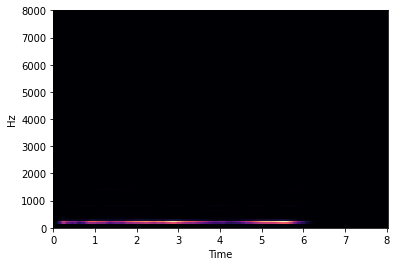

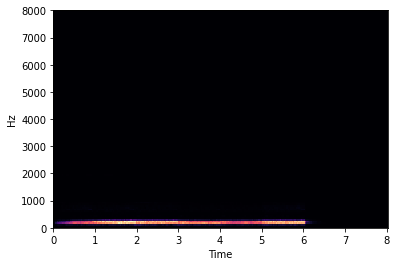

Weights saved in train_results/autoencoder/20200430-175135/model-4000.weights
[0,  4100] loss : 0.0087
[0,  4200] loss : 0.0096
[0,  4300] loss : 0.0126
[0,  4400] loss : 0.0120
[0,  4500] loss : 0.0076
[0,  4600] loss : 0.0078
[0,  4700] loss : 0.0082
[0,  4800] loss : 0.0091
[0,  4900] loss : 0.0087
[0,  5000] loss : 0.0096
Val - loss : 0.0181


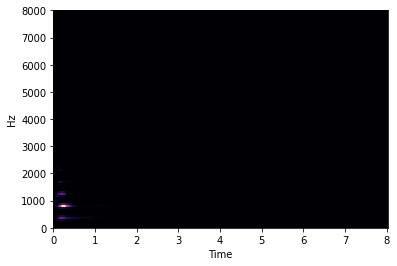

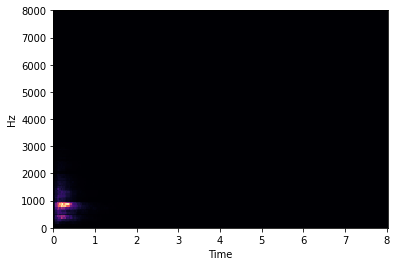

[0,  5100] loss : 0.0161
[0,  5200] loss : 0.0157
[0,  5300] loss : 0.0090
[0,  5400] loss : 0.0096
[0,  5500] loss : 0.0090
[0,  5600] loss : 0.0119
[0,  5700] loss : 0.0146
[0,  5800] loss : 0.0150
[0,  5900] loss : 0.0096
[0,  6000] loss : 0.0066
Val - loss : 0.0162


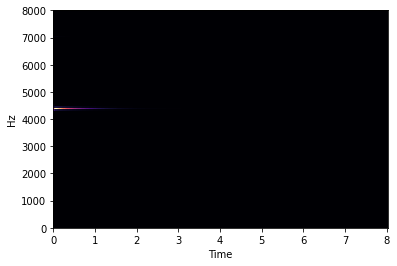

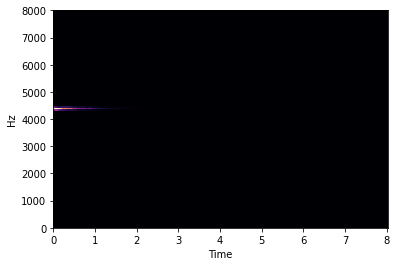

Weights saved in train_results/autoencoder/20200430-175135/model-6000.weights
[0,  6100] loss : 0.0155
[1,  6200] loss : 0.0080
[1,  6300] loss : 0.0124
[1,  6400] loss : 0.0087
[1,  6500] loss : 0.0118
[1,  6600] loss : 0.0107
[1,  6700] loss : 0.0066
[1,  6800] loss : 0.0092
[1,  6900] loss : 0.0082
[1,  7000] loss : 0.0108
Val - loss : 0.0153


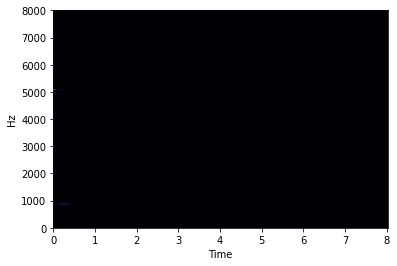

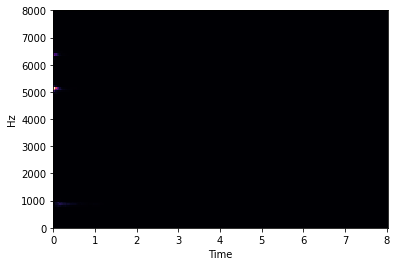

Weights saved in train_results/autoencoder/20200430-175135/model-7000.weights
[1,  7100] loss : 0.0085
[1,  7200] loss : 0.0069
[1,  7300] loss : 0.0129
[1,  7400] loss : 0.0101
[1,  7500] loss : 0.0061
[1,  7600] loss : 0.0118
[1,  7700] loss : 0.0083


In [ ]:
loss_fn = nn.BCELoss()

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
    
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        batch = batch.unsqueeze(1)
        outputs = model(batch)
        
        loss = loss_fn(outputs, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : {:.4f}'.format(epoch, itr, loss.item()), log_file)
            
        if itr % hparams['val_iters'] == 0:
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)
            
            model.eval()
            
            ct, i, val_loss = 0, 0, 0.0
            for batch in val_dataloader:
                i += 1
                ct += batch.size(0)
                batch = batch.unsqueeze(1)
                outputs = model(batch)
                
                loss = loss_fn(outputs, batch)
                val_loss += (loss.item() - val_loss)/i
                
                if ct >= hparams['n_val_samples']:
                    break
            
            print_and_log('Val - loss : {:.4f}'.format(val_loss), log_file)
            librosa.display.specshow(batch[0][0].numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            librosa.display.specshow(outputs[0][0].detach().numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            
            if val_loss < best_loss:
                since_best = 0
                best_loss = val_loss
                
                # save weights
                if ckpt_weights_path:
                    os.remove(ckpt_weights_path)
                ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
                torch.save(model.state_dict(), ckpt_weights_path)
                print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)
                
                # save meta information
                ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
                torch.save({
                    'best_loss' : best_loss,
                    'epoch' : epoch,
                    'itr' : itr,
                    'optimizer' : optimizer.state_dict(),
                    'model' : model.state_dict()
                }, ckpt_meta_path)
            else:
                since_best += 1
                if since_best >= hparams['n_early_stopping']:
                    done = True
                    print_and_log('Early stopping... training complete', log_file)
                    
            model.train()